In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
filename = 'finished_datasets/country.csv'
df = pd.read_csv(filename)

In [3]:
info_col = ['Country', 'Area(sq km)', 'GDP - per capita',
            'Life expectancy at birth(years)', 'Population']
info_df = pd.read_csv('finished_datasets/country_info.csv', usecols=info_col)

## Eliminating countries with missing data

In [4]:
df = df.dropna()

## Shaping the country information dataset

In [5]:
info_df.head()

,Country,Area(sq km),GDP - per capita,Life expectancy at birth(years),Population
0,Angola,1246700,2100,36.61,11190786
1,Argentina,2766890,12400,75.91,39537943
2,Aruba,193,28000,79.14,71566
3,Australia,7686850,30700,80.39,20090437
4,Austria,83870,31300,78.92,8184691


In [6]:
info_df.loc[:, 'Density'] = info_df.Population/info_df['Area(sq km)']
info_df = info_df.drop(['Area(sq km)'], axis=1)

In [7]:
info_df.head()

,Country,GDP - per capita,Life expectancy at birth(years),Population,Density
0,Angola,2100,36.61,11190786,8.976326
1,Argentina,12400,75.91,39537943,14.289669
2,Aruba,28000,79.14,71566,370.808290
3,Australia,30700,80.39,20090437,2.613611
4,Austria,31300,78.92,8184691,97.587826


In [8]:
info_df = info_df.rename(columns={"Country": "country"})

In [9]:
df = df.join(info_df.set_index('country'), on='country')

## Prepping df

In [10]:
df.head()

,country,date,recreation,grocery and pharmacy,parks,transit,workplaces,residential,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths,GDP - per capita,Life expectancy at birth(years),Population,Density
0,United Arab Emirates,2020-09-11,-27.0,-8.0,-48.0,-45.0,-16.0,9.0,77842.0,931.0,8982.0,398.0,0.0,25200,75.24,2563212,30.926786
1,United Arab Emirates,2020-09-12,-22.0,-3.0,-39.0,-42.0,-13.0,7.0,78849.0,1007.0,9467.0,399.0,1.0,25200,75.24,2563212,30.926786
2,United Arab Emirates,2020-09-13,-19.0,0.0,-32.0,-39.0,-20.0,9.0,79489.0,640.0,9639.0,399.0,0.0,25200,75.24,2563212,30.926786
3,United Arab Emirates,2020-09-14,-22.0,-4.0,-36.0,-40.0,-19.0,10.0,80266.0,777.0,9886.0,399.0,0.0,25200,75.24,2563212,30.926786
4,United Arab Emirates,2020-09-15,-22.0,-4.0,-36.0,-40.0,-19.0,10.0,80940.0,674.0,9904.0,401.0,2.0,25200,75.24,2563212,30.926786


In order to control for days of the week un-comment the cell below. However, be warned that it lowers the R2 and makes daily_new_cases statistically irrelevant.

In [11]:
#df['date'] = pd.to_datetime(df['date'])
#df['dw'] = df['date'].dt.day_name()
#df = pd.get_dummies(df, columns=['dw'])

In [12]:
df = df.drop(['cumulative_total_deaths', 'cumulative_total_cases'], axis=1)

In [13]:
df = pd.get_dummies(df, columns=['country'])

In [14]:
np.shape(df)

(16434, 113)

We are dropping a country to avoid multicolinearity.

In [15]:
df = df.drop(['country_Venezuela'], axis=1)

## Non linear relationships

We decided to test 3 different non linear relationships. The linear-log, a second degree polynomial and a third degree polynomial.

In [16]:
X_square = df.drop(['recreation', 'grocery and pharmacy', 'parks', 'transit',
             'workplaces', 'date', 'residential'], axis=1).copy()
X_square = sm.add_constant(X_square)

X_log = df.drop(['recreation', 'grocery and pharmacy', 'parks', 'transit',
             'workplaces', 'date', 'residential'], axis=1).copy()
X_log = sm.add_constant(X_log)

In [17]:
X_square.loc[:, 'daily_new_cases2'] = df.daily_new_cases**2
X_square.loc[:, 'daily_new_cases3'] = df.daily_new_cases**3
X_square.loc[:, 'daily_new_cases'] = df.daily_new_cases


In [18]:
X_log.loc[:, 'daily_new_cases'] = np.log(1+df.loc[:,'daily_new_cases'])

In [19]:
y = df.loc[:, 'recreation']
model2=sm.RLM(y,X_square.loc[:, ['const', 'daily_new_cases', 'daily_new_cases2']])
results2 = model2.fit()

model3=sm.RLM(y,X_square.loc[:, ['const', 'daily_new_cases', 'daily_new_cases2', 'daily_new_cases3']])
results3 = model3.fit()

model_log = sm.RLM(y, X_log.loc[:, ['const', 'daily_new_cases']])
results_log = model_log.fit()

In [20]:
x = np.linspace(min(X_square.daily_new_cases), max(X_square.daily_new_cases), 100)
mat2 = np.ones(3*len(x)).reshape(len(x), 3)
mat2[:, 1] = x
mat2[:, 2] = x**2

mat3 = np.ones(4*len(x)).reshape(len(x), 4)
mat3[:, 1] = x
mat3[:, 2] = x**2
mat3[:, 3] = x**3

In [21]:
x_log = np.linspace(min(X_square.daily_new_cases), max(X_square.daily_new_cases), 100)
mat_log = np.ones(2*len(x)).reshape(len(x), 2)
mat_log[:, 1] = np.log(x_log+1)

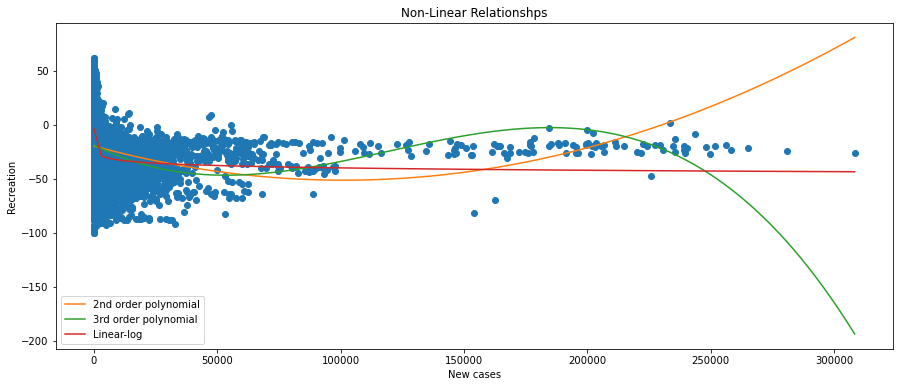

In [22]:
plt.figure(figsize=(15,6))
plt.title('Non-Linear Relationshps')
plt.xlabel('New cases')
plt.ylabel('Recreation')
plt.scatter(X_square.daily_new_cases, df.recreation)
plt.plot(mat2[:, 1], results2.predict(mat2) , color='C1', label='2nd order polynomial')
plt.plot(mat3[:, 1], results3.predict(mat3) , color='C2', label='3rd order polynomial')
plt.plot(x_log, results_log.predict(mat_log), color='C3', label='Linear-log')
plt.legend()
plt.show()

After observing the non-linear relationships, we decided to use the linear-log

## Regression

An increase of 1% in ... causes a 1% increase in ... :

Also, the variables with "int" are the interaction terms. They should be interpreted as:

1% change in X1 causes a 1% change in X2

In [23]:
X = df.drop(['recreation', 'grocery and pharmacy', 'parks', 'transit',
             'workplaces', 'date', 'residential'], axis=1).copy()
X = sm.add_constant(X)
X.loc[:, 'daily_new_cases'] = np.log(1+X.loc[:, 'daily_new_cases'])
X.loc[:, 'active_cases'] = np.log(1+X.loc[:, 'active_cases'])
X.loc[:, 'daily_new_deaths'] = np.log(1+X.loc[:, 'daily_new_deaths'])

X.loc[:, 'int_new_active'] = X.loc[:, 'daily_new_cases'] * X.loc[:, 'active_cases']
X.loc[:, 'int_death_active'] = X.loc[:, 'daily_new_deaths'] * X.loc[:, 'active_cases']
X.loc[:, 'int_new_death'] = X.loc[:, 'daily_new_cases'] * X.loc[:, 'daily_new_deaths']

y = df.loc[:, 'recreation']

In [24]:
model=sm.RLM(y,X)
results = model.fit() 

In [25]:
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             recreation   No. Observations:                16434
Model:                            RLM   Df Residuals:                    16329
Method:                          IRLS   Df Model:                          104
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 05 Apr 2021                                         
Time:                        22:34:11                                         
No. Iterations:                    50                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [26]:
y = df.loc[:, 'grocery and pharmacy']
model=sm.RLM(y,X)
results = model.fit()
print(results.summary())

                     Robust linear Model Regression Results                     
Dep. Variable:     grocery and pharmacy   No. Observations:                16434
Model:                              RLM   Df Residuals:                    16329
Method:                            IRLS   Df Model:                          104
Norm:                            HuberT                                         
Scale Est.:                         mad                                         
Cov Type:                            H1                                         
Date:                  Mon, 05 Apr 2021                                         
Time:                          22:34:15                                         
No. Iterations:                      50                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [27]:
y = df.loc[:, 'parks']
model=sm.RLM(y,X)
results = model.fit()
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  parks   No. Observations:                16434
Model:                            RLM   Df Residuals:                    16329
Method:                          IRLS   Df Model:                          104
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 05 Apr 2021                                         
Time:                        22:34:19                                         
No. Iterations:                    50                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [28]:
y = df.loc[:, 'transit']
model=sm.RLM(y,X)
results = model.fit()
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                transit   No. Observations:                16434
Model:                            RLM   Df Residuals:                    16329
Method:                          IRLS   Df Model:                          104
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 05 Apr 2021                                         
Time:                        22:34:23                                         
No. Iterations:                    50                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [29]:
y = df.loc[:, 'workplaces']
model=sm.RLM(y,X)
results = model.fit()
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             workplaces   No. Observations:                16434
Model:                            RLM   Df Residuals:                    16329
Method:                          IRLS   Df Model:                          104
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 05 Apr 2021                                         
Time:                        22:34:27                                         
No. Iterations:                    50                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [30]:
y = df.loc[:, 'residential']
model=sm.RLM(y,X)
results = model.fit()
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:            residential   No. Observations:                16434
Model:                            RLM   Df Residuals:                    16329
Method:                          IRLS   Df Model:                          104
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 05 Apr 2021                                         
Time:                        22:34:30                                         
No. Iterations:                    50                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     